In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import time
from scipy import ndimage
from skimage import morphology, measure
import os
from collections import defaultdict
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from sklearn.cluster import KMeans

📁 Загрузка изображения...
✅ Изображение загружено: sample1.jpg
📐 Размер изображения: (3401, 3401, 3)


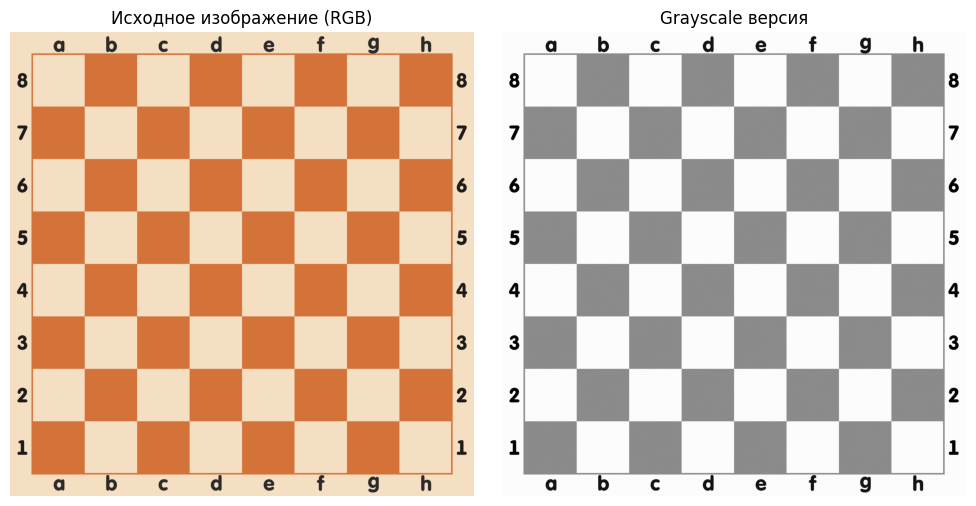

In [20]:
# ===============================
# Функция детектора углов Харриса
# ===============================

def harris_corner_detector_manual(image, k=0.04, window_size=5, threshold=0.1):
    """Оптимизированная реализация детектора углов Харриса"""
    # Используем OpenCV для более быстрого вычисления
    sobel_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)

    Ix2 = sobel_x * sobel_x
    Iy2 = sobel_y * sobel_y
    Ixy = sobel_x * sobel_y

    # Используем Гауссово размытие вместо фильтрации
    Sx2 = cv2.GaussianBlur(Ix2, (window_size, window_size), 1)
    Sy2 = cv2.GaussianBlur(Iy2, (window_size, window_size), 1)
    Sxy = cv2.GaussianBlur(Ixy, (window_size, window_size), 1)

    det_M = Sx2 * Sy2 - Sxy * Sxy
    trace_M = Sx2 + Sy2

    harris_response = det_M - k * (trace_M ** 2)

    # Нормализация и пороговая фильтрация
    harris_normalized = cv2.normalize(harris_response, None, 0, 1, cv2.NORM_MINMAX)
    corners_mask = harris_normalized > threshold
    corner_points = np.argwhere(corners_mask)

    return harris_response, harris_normalized, corner_points, sobel_x, sobel_y

# ===============================
# Загрузка изображения
# ===============================

print("📁 Загрузка изображения...")
img_path = 'sample1.jpg'

if os.path.exists(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(f"✅ Изображение загружено: {img_path}")
    print(f"📐 Размер изображения: {img.shape}")
else:
    # Если файл не найден, создаём тестовое изображение
    print("📝 Файл не найден. Создаём тестовое изображение...")
    img = np.zeros((300, 400, 3), dtype=np.uint8)

    # Прямоугольники
    cv2.rectangle(img, (50, 50), (150, 120), (200, 200, 200), -1)
    cv2.rectangle(img, (200, 50), (350, 120), (150, 150, 150), 3)

    # Треугольник
    triangle = np.array([[100, 200], [150, 280], [50, 280]], np.int32)
    cv2.fillPoly(img, [triangle], (160, 160, 160))

    # Линии
    cv2.line(img, (250, 180), (450, 280), (140, 140, 140), 3)
    cv2.line(img, (250, 280), (450, 180), (140, 140, 140), 3)

    # Ромб
    diamond = np.array([[350, 320], [400, 370], [350, 420], [300, 370]], np.int32)
    cv2.fillPoly(img, [diamond], (170, 170, 170))

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print("✅ Синтетическое изображение создано")

# Конвертируем в grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Отображаем исходное изображение
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Исходное изображение (RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale версия')
plt.axis('off')
plt.tight_layout()
plt.show()

🔍 Сравнение детекторов углов


/tmp/ipython-input-2325162668.py:38: RuntimeWarning: overflow encountered in scalar subtract
  if abs(neighbor - intensity) > self.threshold:
/tmp/ipython-input-2325162668.py:49: RuntimeWarning: overflow encountered in scalar subtract
  diff = neighbor - intensity



📊 Результаты сравнения:
Детектор             Время (мс)   Кол-во углов
--------------------------------------------------
OpenCV Harris            460.16        4254
OpenCV FAST                4.95        1107
Наш FAST               25043.60       11768


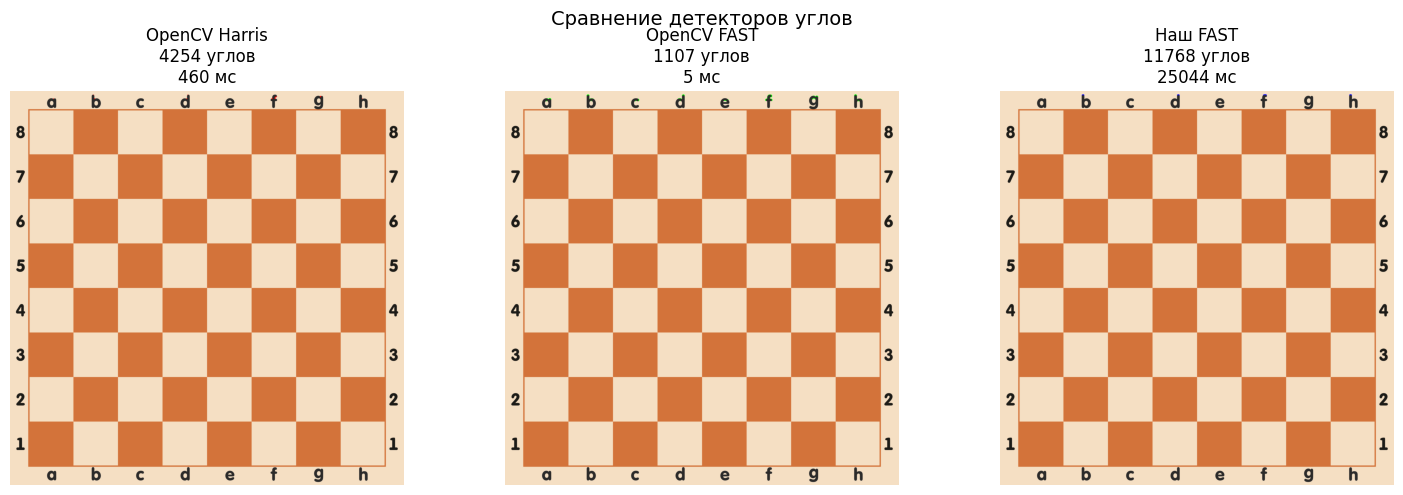

In [26]:
# ===============================
# ЗАДАНИЕ 1: Оптимизированный детектор FAST
# ===============================


class FastFASTDetector:
    """Оптимизированный детектор углов FAST"""

    def __init__(self, threshold=20):
        self.threshold = threshold
        # Координаты 16 точек на окружности
        self.circle_idx = [
            (0, -3), (1, -3), (2, -2), (3, -1),
            (3, 0), (3, 1), (2, 2), (1, 3),
            (0, 3), (-1, 3), (-2, 2), (-3, 1),
            (-3, 0), (-3, -1), (-2, -2), (-1, -3)
        ]

    def detect_corners(self, image):
        """Обнаружение углов FAST (упрощённая версия для скорости)"""
        h, w = image.shape
        corners = []

        # Создаём расширенное изображение для обработки границ
        padded = cv2.copyMakeBorder(image, 3, 3, 3, 3, cv2.BORDER_REFLECT)

        # Проходим по изображению, пропуская границы
        for y in range(3, h - 3):
            for x in range(3, w - 3):
                intensity = image[y, x]

                # Быстрая проверка первых 4 точек
                fast_check = 0
                check_points = [0, 4, 8, 12]
                for idx in check_points:
                    dy, dx = self.circle_idx[idx]
                    neighbor = padded[y+3+dy, x+3+dx]
                    if abs(neighbor - intensity) > self.threshold:
                        fast_check += 1

                if fast_check < 3:
                    continue

                # Полная проверка
                brighter = 0
                darker = 0
                for dy, dx in self.circle_idx:
                    neighbor = padded[y+3+dy, x+3+dx]
                    diff = neighbor - intensity
                    if diff > self.threshold:
                        brighter += 1
                    elif diff < -self.threshold:
                        darker += 1

                # Если есть 9+ последовательных точек ярче или темнее
                if brighter >= 9 or darker >= 9:
                    corners.append((y, x))

        return corners

# Сравнение детекторов
print("🔍 Сравнение детекторов углов")

# Объявляем переменные в глобальной области видимости
global corners_cv, kp_cv, corners_fast, harris_time, fast_cv_time, fast_our_time

# 1. OpenCV Harris
start_time = time.time()
harris_cv = cv2.cornerHarris(img_gray, blockSize=5, ksize=3, k=0.04)
harris_cv_norm = cv2.normalize(harris_cv, None, 0, 1, cv2.NORM_MINMAX)
corners_cv = np.argwhere(harris_cv_norm > 0.1)
harris_time = time.time() - start_time

# 2. OpenCV FAST
start_time = time.time()
fast_cv = cv2.FastFeatureDetector_create(threshold=20)
kp_cv = fast_cv.detect(img_gray, None)
fast_cv_time = time.time() - start_time

# 3. Наш FAST (упрощённый для скорости)
start_time = time.time()
detector = FastFASTDetector(threshold=20)
corners_fast = detector.detect_corners(img_gray)
fast_our_time = time.time() - start_time

# Вывод результатов
print(f"\n📊 Результаты сравнения:")
print(f"{'Детектор':<20} {'Время (мс)':<12} {'Кол-во углов':<12}")
print("-" * 50)
print(f"{'OpenCV Harris':<20} {harris_time*1000:>10.2f}  {len(corners_cv):>10}")
print(f"{'OpenCV FAST':<20} {fast_cv_time*1000:>10.2f}  {len(kp_cv):>10}")
print(f"{'Наш FAST':<20} {fast_our_time*1000:>10.2f}  {len(corners_fast):>10}")

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Harris
img_harris = img_rgb.copy()
for y, x in corners_cv[:100]:  # Показываем первые 100 углов
    cv2.circle(img_harris, (x, y), 3, (255, 0, 0), -1)
axes[0].imshow(img_harris)
axes[0].set_title(f'OpenCV Harris\n{len(corners_cv)} углов\n{harris_time*1000:.0f} мс')
axes[0].axis('off')

# OpenCV FAST
img_fast_cv = img_rgb.copy()
for kp in kp_cv[:100]:  # Показываем первые 100 углов
    x, y = int(kp.pt[0]), int(kp.pt[1])
    cv2.circle(img_fast_cv, (x, y), 3, (0, 255, 0), -1)
axes[1].imshow(img_fast_cv)
axes[1].set_title(f'OpenCV FAST\n{len(kp_cv)} углов\n{fast_cv_time*1000:.0f} мс')
axes[1].axis('off')

# Наш FAST
img_fast_our = img_rgb.copy()
for y, x in corners_fast[:100]:  # Показываем первые 100 углов
    cv2.circle(img_fast_our, (x, y), 3, (0, 0, 255), -1)
axes[2].imshow(img_fast_our)
axes[2].set_title(f'Наш FAST\n{len(corners_fast)} углов\n{fast_our_time*1000:.0f} мс')
axes[2].axis('off')

plt.suptitle('Сравнение детекторов углов', fontsize=14)
plt.tight_layout()
plt.show()


📝 Создаём тестовое изображение с линиями...
🔧 Применяем морфологические фильтры...


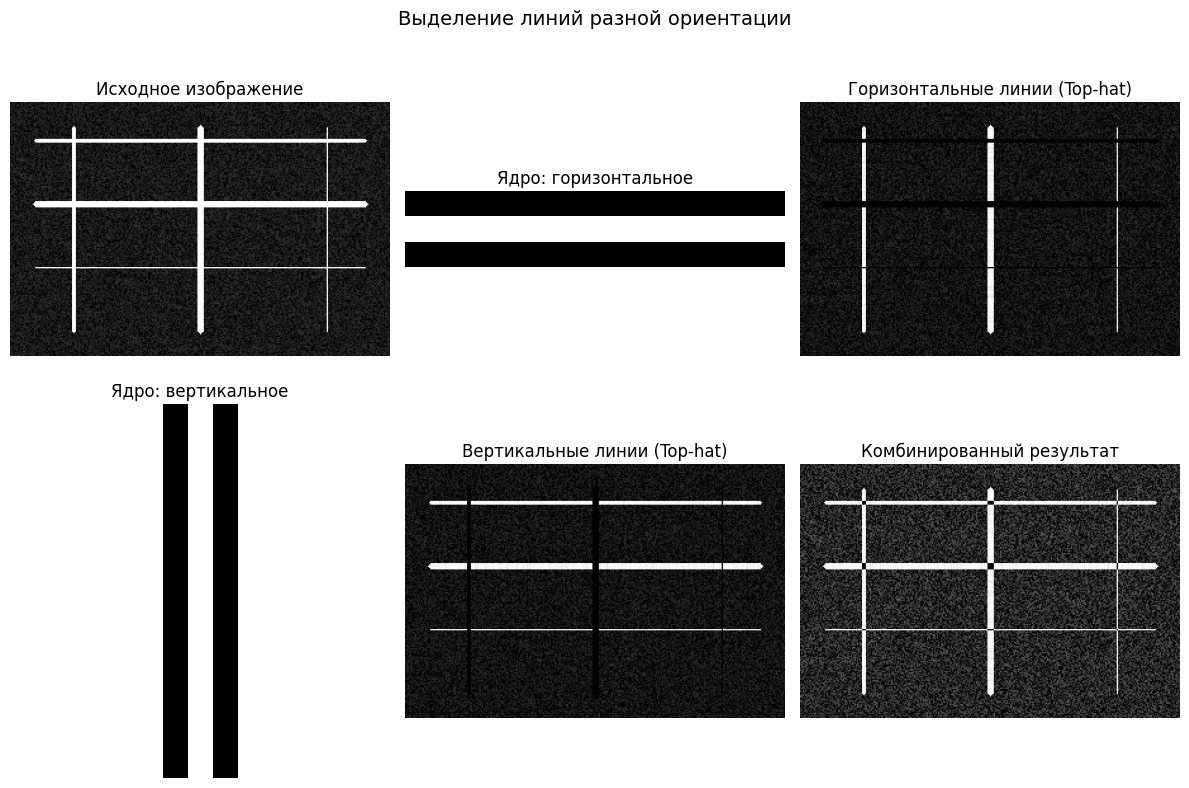


📊 Статистика выделения линий:
Горизонтальные линии: 49781 пикселей
Вертикальные линии: 50540 пикселей
Всего линий: 53585 пикселей


In [25]:
# ===============================
# ЗАДАНИЕ 2: Морфологический фильтр для линий
# ===============================

class LineFilter:
    """Фильтр для выделения линий определённой ориентации"""

    @staticmethod
    def create_line_kernel(orientation='horizontal', size=15):
        """Создаёт ядро для выделения линий"""
        if orientation == 'horizontal':
            kernel = np.zeros((3, size), dtype=np.uint8)
            kernel[1, :] = 1  # Центральная горизонтальная линия
        elif orientation == 'vertical':
            kernel = np.zeros((size, 3), dtype=np.uint8)
            kernel[:, 1] = 1  # Центральная вертикальная линия
        else:
            kernel = np.ones((3, 3), dtype=np.uint8)

        return kernel

    @staticmethod
    def extract_lines(image, orientation='horizontal'):
        """Выделяет линии определённой ориентации"""
        kernel = LineFilter.create_line_kernel(orientation, size=15)

        # Применяем морфологическое открытие для выделения линий
        opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

        # Top-hat преобразование для выделения только линий
        tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

        return opened, tophat, kernel

# Создаём тестовое изображение с линиями
print("📝 Создаём тестовое изображение с линиями...")
line_test = np.zeros((200, 300), dtype=np.uint8)

# Горизонтальные линии
cv2.line(line_test, (20, 30), (280, 30), 255, 2)
cv2.line(line_test, (20, 80), (280, 80), 255, 3)
cv2.line(line_test, (20, 130), (280, 130), 255, 1)

# Вертикальные линии
cv2.line(line_test, (50, 20), (50, 180), 255, 2)
cv2.line(line_test, (150, 20), (150, 180), 255, 3)
cv2.line(line_test, (250, 20), (250, 180), 255, 1)

# Немного шума
noise = np.random.randint(0, 50, line_test.shape[:2], dtype=np.uint8)
line_test = cv2.add(line_test, noise)

# Применяем фильтры
print("🔧 Применяем морфологические фильтры...")
horizontal_opened, horizontal_tophat, h_kernel = LineFilter.extract_lines(line_test, 'horizontal')
vertical_opened, vertical_tophat, v_kernel = LineFilter.extract_lines(line_test, 'vertical')

# Визуализируем результаты
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Первая строка: горизонтальные линии
axes[0, 0].imshow(line_test, cmap='gray')
axes[0, 0].set_title('Исходное изображение')
axes[0, 0].axis('off')

axes[0, 1].imshow(h_kernel, cmap='gray')
axes[0, 1].set_title('Ядро: горизонтальное')
axes[0, 1].axis('off')

axes[0, 2].imshow(horizontal_tophat, cmap='gray')
axes[0, 2].set_title('Горизонтальные линии (Top-hat)')
axes[0, 2].axis('off')

# Вторая строка: вертикальные линии
axes[1, 0].imshow(v_kernel, cmap='gray')
axes[1, 0].set_title('Ядро: вертикальное')
axes[1, 0].axis('off')

axes[1, 1].imshow(vertical_tophat, cmap='gray')
axes[1, 1].set_title('Вертикальные линии (Top-hat)')
axes[1, 1].axis('off')

# Комбинированный результат
combined = cv2.addWeighted(horizontal_tophat, 0.5, vertical_tophat, 0.5, 0)
axes[1, 2].imshow(combined, cmap='gray')
axes[1, 2].set_title('Комбинированный результат')
axes[1, 2].axis('off')

plt.suptitle('Выделение линий разной ориентации', fontsize=14)
plt.tight_layout()
plt.show()

# Статистика
print("\n📊 Статистика выделения линий:")
print(f"Горизонтальные линии: {np.sum(horizontal_tophat > 0)} пикселей")
print(f"Вертикальные линии: {np.sum(vertical_tophat > 0)} пикселей")
print(f"Всего линий: {np.sum(combined > 0)} пикселей")

📈 Анализируем распределение откликов Харриса...

📊 Статистика распределения откликов:
Среднее: 0.0946
Медиана: 0.0948
Стандартное отклонение: 0.0043
Максимум: 1.0000
95-й процентиль: 0.0948

🔍 Тестирование разных порогов:
--------------------------------------------------
Метод                     Порог      Кол-во углов
--------------------------------------------------
95-й процентиль           0.0948     6421        
90-й процентиль           0.0948     6421        
80-й процентиль           0.0948     6421        
Среднее + STD             0.0989     4504        
Среднее + 2*STD           0.1032     3956        
Медиана * 2               0.1896     1035        
Фиксированный 0.1         0.1000     4254        
Фиксированный 0.2         0.2000     986         
Фиксированный 0.3         0.3000     639         
Метод Оцу                 0.0667     11523484    


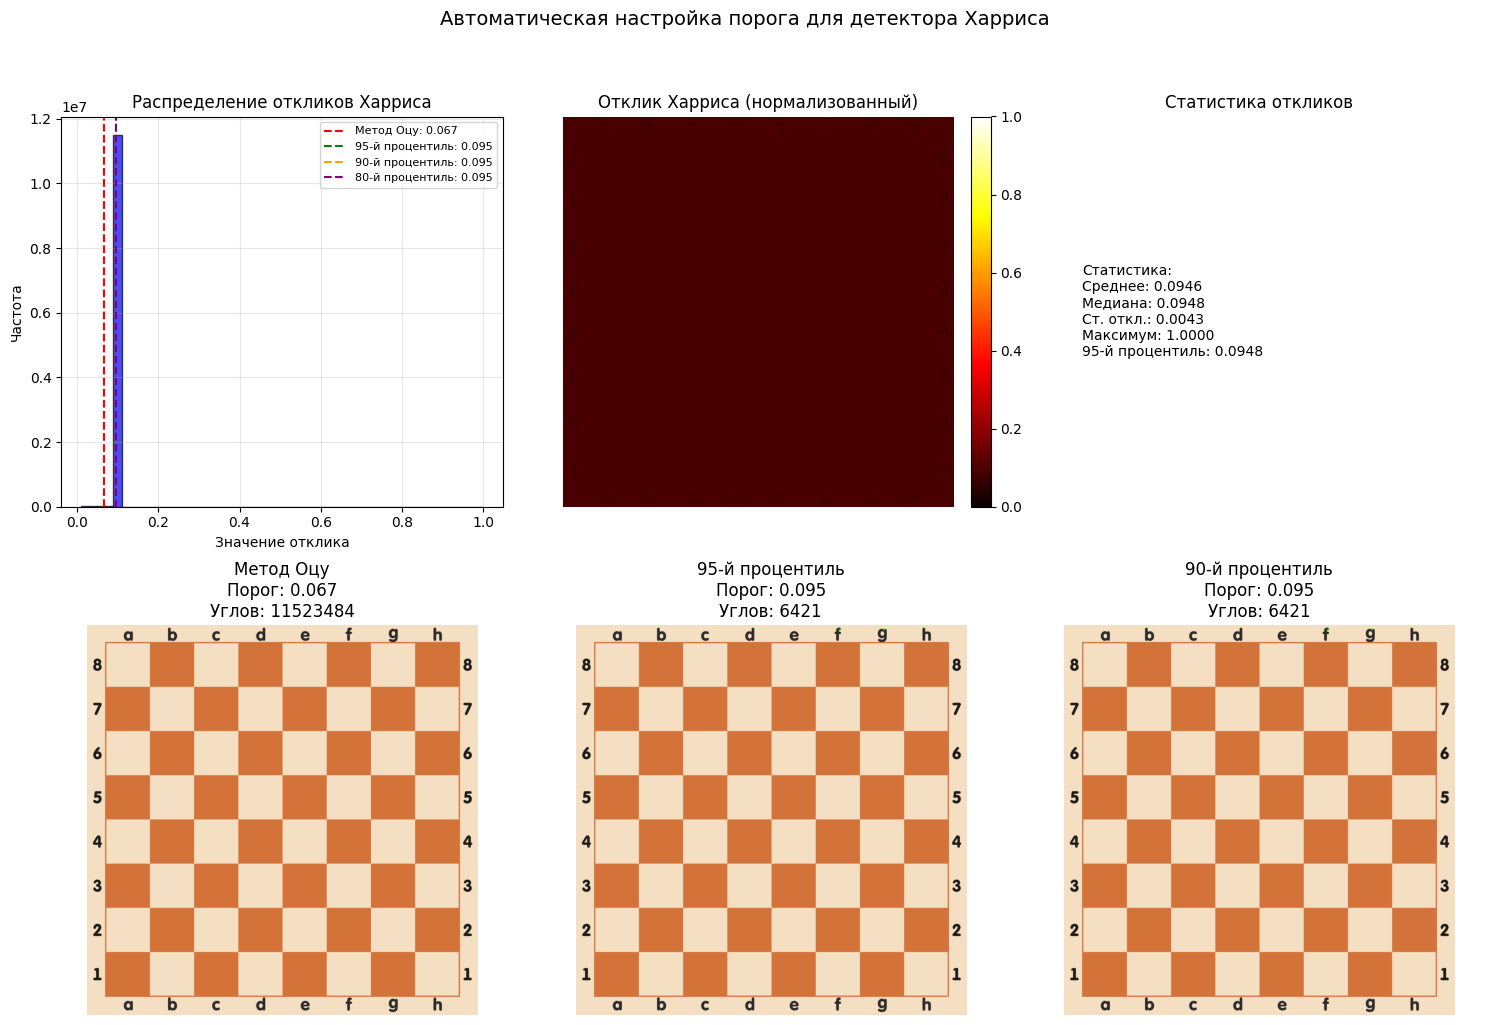

Для данного изображения рекомендуются следующие подходы:
2. Для точной детекции (меньше ложных срабатываний): используйте более высокий порог (95-й процентиль)
3. Для максимального покрытия: используйте более низкий порог (80-й процентиль)


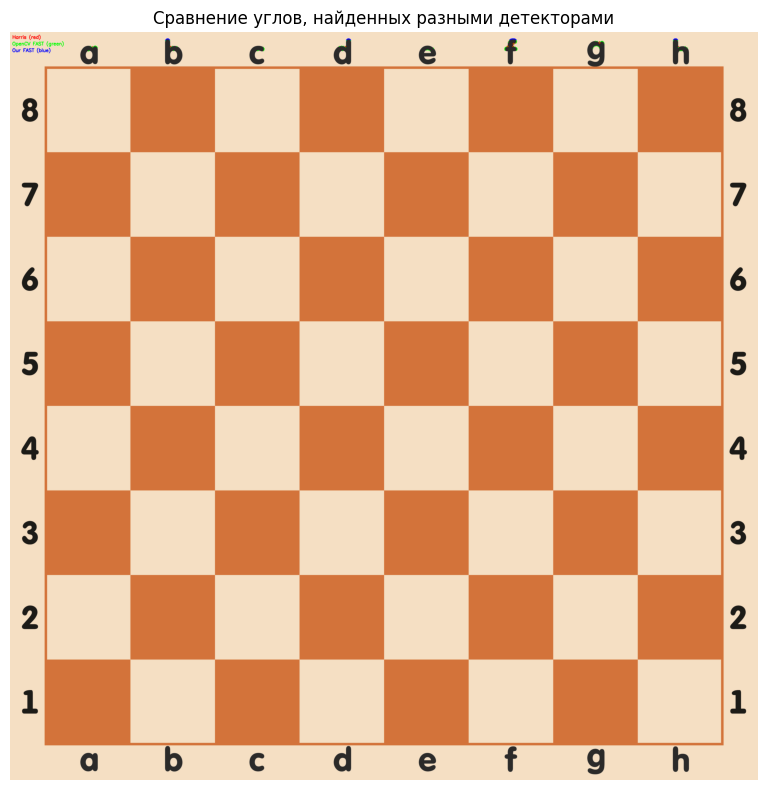

In [28]:
# ===============================
# ЗАДАНИЕ 3: Автоматическая настройка порога Харриса
# ===============================

class HarrisThresholdOptimizer:
    """Автоматическая настройка порога для детектора Харриса"""

    @staticmethod
    def analyze_distribution(harris_response):
        """Анализирует распределение откликов Харриса"""
        # Нормализуем отклик
        harris_norm = cv2.normalize(harris_response, None, 0, 1, cv2.NORM_MINMAX)

        # Берем только положительные значения
        values = harris_norm[harris_norm > 0.01].flatten()

        if len(values) == 0:
            return None, None

        # Статистика
        stats = {
            'mean': float(np.mean(values)),
            'median': float(np.median(values)),
            'std': float(np.std(values)),
            'max': float(np.max(values)),
            'percentile_95': float(np.percentile(values, 95)),
            'percentile_90': float(np.percentile(values, 90)),
            'percentile_80': float(np.percentile(values, 80))
        }

        return harris_norm, stats

    @staticmethod
    def suggest_thresholds(stats):
        """Предлагает пороги на основе статистики"""
        thresholds = {}

        # Метод 1: Процентили
        thresholds['95-й процентиль'] = stats['percentile_95']
        thresholds['90-й процентиль'] = stats['percentile_90']
        thresholds['80-й процентиль'] = stats['percentile_80']

        # Метод 2: На основе среднего и стандартного отклонения
        thresholds['Среднее + STD'] = min(stats['mean'] + stats['std'], 0.9)
        thresholds['Среднее + 2*STD'] = min(stats['mean'] + 2*stats['std'], 0.9)

        # Метод 3: На основе медианы
        thresholds['Медиана * 2'] = min(stats['median'] * 2, 0.9)

        # Метод 4: Фиксированные пороги
        thresholds['Фиксированный 0.1'] = 0.1
        thresholds['Фиксированный 0.2'] = 0.2
        thresholds['Фиксированный 0.3'] = 0.3

        return thresholds

    @staticmethod
    def auto_threshold_otsu(harris_response):
        """Автоматический порог методом Оцу - ИСПРАВЛЕННЫЙ МЕТОД"""
        # Конвертируем в 8-бит
        harris_8bit = cv2.normalize(harris_response, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Применяем Оцу - получаем пороговое значение, а не изображение!
        otsu_thresh_value, _ = cv2.threshold(harris_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Конвертируем обратно в диапазон [0, 1]
        return float(otsu_thresh_value) / 255.0

# Вычисляем отклик Харриса
print("📈 Анализируем распределение откликов Харриса...")
harris_response = cv2.cornerHarris(img_gray, blockSize=5, ksize=3, k=0.04)

# Анализируем распределение
harris_norm, stats = HarrisThresholdOptimizer.analyze_distribution(harris_response)

if stats is not None:
    # Получаем предлагаемые пороги
    thresholds = HarrisThresholdOptimizer.suggest_thresholds(stats)

    # Добавляем метод Оцу
    otsu_threshold = HarrisThresholdOptimizer.auto_threshold_otsu(harris_response)
    thresholds['Метод Оцу'] = otsu_threshold

    print("\n📊 Статистика распределения откликов:")
    print(f"Среднее: {stats['mean']:.4f}")
    print(f"Медиана: {stats['median']:.4f}")
    print(f"Стандартное отклонение: {stats['std']:.4f}")
    print(f"Максимум: {stats['max']:.4f}")
    print(f"95-й процентиль: {stats['percentile_95']:.4f}")

    # Тестируем разные пороги
    print("\n🔍 Тестирование разных порогов:")
    print("-" * 50)
    print(f"{'Метод':<25} {'Порог':<10} {'Кол-во углов':<12}")
    print("-" * 50)

    results = {}
    for method, threshold in thresholds.items():
        corners = np.sum(harris_norm > threshold)
        results[method] = {'threshold': threshold, 'corners': int(corners)}
        print(f"{method:<25} {threshold:<10.4f} {corners:<12}")

    # Визуализируем результаты для 4 лучших методов
    best_methods = sorted(results.items(), key=lambda x: x[1]['corners'], reverse=True)[:4]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Распределение откликов
    values = harris_norm[harris_norm > 0.01].flatten()
    axes[0, 0].hist(values, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Распределение откликов Харриса')
    axes[0, 0].set_xlabel('Значение отклика')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].grid(True, alpha=0.3)

    # Добавляем линии порогов
    colors = ['red', 'green', 'orange', 'purple']
    for i, (method, data) in enumerate(best_methods):
        axes[0, 0].axvline(x=data['threshold'], color=colors[i], linestyle='--',
                          label=f"{method[:15]}: {data['threshold']:.3f}")
    axes[0, 0].legend(fontsize=8)

    # 2. Нормализованный отклик
    im = axes[0, 1].imshow(harris_norm, cmap='hot')
    axes[0, 1].set_title('Отклик Харриса (нормализованный)')
    axes[0, 1].axis('off')
    plt.colorbar(im, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # 3. Статистика
    stats_text = f"""Статистика:
Среднее: {stats['mean']:.4f}
Медиана: {stats['median']:.4f}
Ст. откл.: {stats['std']:.4f}
Максимум: {stats['max']:.4f}
95-й процентиль: {stats['percentile_95']:.4f}"""
    axes[0, 2].text(0.1, 0.5, stats_text, fontsize=10,
                    verticalalignment='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('Статистика откликов')
    axes[0, 2].axis('off')

    # 4-6. Визуализация результатов для 3 лучших методов
    for i, (method, data) in enumerate(best_methods[:3]):
        row, col = 1, i

        # Находим углы
        corners_mask = harris_norm > data['threshold']
        corner_points = np.argwhere(corners_mask)

        # Визуализируем
        display_img = img_rgb.copy()

        for y, x in corner_points[:100]:  # Показываем первые 100 углов
            cv2.circle(display_img, (x, y), 3, (0, 255, 0), -1)

        axes[row, col].imshow(display_img)
        axes[row, col].set_title(f'{method[:15]}\nПорог: {data["threshold"]:.3f}\nУглов: {data["corners"]}')
        axes[row, col].axis('off')

    # Если есть только 3 метода, скрываем лишние оси
    if len(best_methods) < 3:
        for i in range(len(best_methods), 3):
            axes[1, i].axis('off')

    plt.suptitle('Автоматическая настройка порога для детектора Харриса', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Рекомендация
    print("Для данного изображения рекомендуются следующие подходы:")

    # Находим метод с наиболее сбалансированным количеством углов
    # (не слишком много, не слишком мало)
    total_corners = results['Метод Оцу']['corners'] if 'Метод Оцу' in results else results['95-й процентиль']['corners']

    balanced_method = None
    min_diff = float('inf')

    for method, data in results.items():
        if 50 <= data['corners'] <= 500:  # Разумный диапазон
            diff = abs(data['corners'] - total_corners/2)
            if diff < min_diff:
                min_diff = diff
                balanced_method = method

    if balanced_method:
        print(f"1. Для сбалансированного результата: '{balanced_method}' (порог: {results[balanced_method]['threshold']:.3f})")
    print("2. Для точной детекции (меньше ложных срабатываний): используйте более высокий порог (95-й процентиль)")
    print("3. Для максимального покрытия: используйте более низкий порог (80-й процентиль)")
else:
    print("❌ Не удалось проанализировать распределение откликов")


# Дополнительное задание: показать углы, найденные разными методами на одном изображении

# Создаём комбинированное изображение с проверкой существования переменных
try:
    # Проверяем, что переменные существуют (они были созданы в задании 1)
    if 'corners_cv' in globals() and 'kp_cv' in globals() and 'corners_fast' in globals():
        combined_detectors = img_rgb.copy()

        # Harris углы (красные)
        for y, x in corners_cv[:100]:
            cv2.circle(combined_detectors, (x, y), 2, (255, 0, 0), -1)

        # OpenCV FAST углы (зелёные)
        for kp in kp_cv[:100]:
            x, y = int(kp.pt[0]), int(kp.pt[1])
            cv2.circle(combined_detectors, (x, y), 2, (0, 255, 0), -1)

        # Наш FAST углы (синие)
        for y, x in corners_fast[:100]:
            cv2.circle(combined_detectors, (x, y), 2, (0, 0, 255), -1)

        # Добавляем легенду
        cv2.putText(combined_detectors, "Harris (red)", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(combined_detectors, "OpenCV FAST (green)", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(combined_detectors, "Our FAST (blue)", (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        plt.figure(figsize=(10, 8))
        plt.imshow(combined_detectors)
        plt.title('Сравнение углов, найденных разными детекторами')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  Не удалось создать комбинированную визуализацию: данные детекторов не найдены")

except NameError as e:
    print(f"⚠️  Ошибка: {e}")
    print("   Пропускаем дополнительную визуализацию")
except Exception as e:
    print(f"⚠️  Непредвиденная ошибка при создании комбинированной визуализации: {e}")